In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import torch
import torch.nn.functional as F
import torchvision.models as models
import shutil

from PIL import Image, ImageOps
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from typing import Tuple
from tqdm import tqdm
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

In [ ]:
# Download data
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip

In [ ]:
# Unzip data
!unzip train2014.zip
!unzip val2014.zip

In [4]:
# DataLoader

class ImageDataset(Dataset):
    def __init__(self, data_path: str, transformation, resize_width=224, resize_height=224):
        self.__data_path = data_path
        self.__file_names = os.listdir(self.__data_path)
        self.__resize = (resize_width, resize_height)
        self.__transformation = transformation

    def __len__(self):
        return len(self.__file_names)

    def __getitem__(self, idx):
        full_path = os.path.join(self.__data_path, self.__file_names[idx])
        # print(full_path)
        img = Image.open(full_path).convert("RGB").resize(self.__resize)
        # img = self.__transformation(img)
        img = np.asarray(img)

        img_lab = rgb2lab(img)
        # img_lab = (img_lab + 128) / 255


        img_ab = img_lab[:, :, 1:3]
        img_ab = (img_ab + 128) / 255
        img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()

        img_gray = img_lab[:, :, 0]
        img_gray = img_gray / 100
        img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()

        return img_gray, img_ab


In [5]:
# Colorizer
class Colorizer(nn.Module):
    def __init__(self, input_size=128, features_size=128):
        super(Colorizer, self).__init__()

        resnet = models.resnet18(num_classes=365) 
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        
        self.upsample = nn.Sequential(     
            nn.Conv2d(features_size, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, input):
        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_resnet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output

In [5]:
# Trainer
class Trainer:
    def __init__(self, model, loss_fn, optimizer, learning_rate=1e-3, epochs=10):
        self.__model = model
        self.__loss_fn = loss_fn
        self.__optimizer = optimizer
        self.__learning_rate = learning_rate
        self.__epochs = epochs

    def train_loop(self, dataloader):
        self.__model.train()
        size = len(dataloader.dataset)
        for batch, (input_gray, input_ab) in tqdm(enumerate(dataloader)):
            input_gray = input_gray.to('cuda')

            input_ab = input_ab.to('cuda')
            output_ab = self.__model(input_gray)

            loss = self.__loss_fn(output_ab, input_ab)

            # Backpropagation
            self.__optimizer.zero_grad()
            loss.backward()
            self.__optimizer.step()

            if batch % 64 == 0:
                loss, current = loss.item(), batch * len(input_gray)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def test_loop(self, dataloader):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for input_gray, input_ab in tqdm(dataloader):

                input_gray = input_gray.to('cuda')

                input_ab = input_ab.to('cuda')
                output_ab = self.__model(input_gray)

                test_loss += self.__loss_fn(output_ab, input_ab).item()

        test_loss /= num_batches
        print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

    def run_epochs(self, train_dataloader, test_dataloader):
        for epoch in range(self.__epochs):
            print(f"Epoch {epoch + 1}\n-------------------------------")
            self.train_loop(train_dataloader)

        self.test_loop(test_dataloader)
        print("Done!")

In [ ]:
colorizer = Colorizer().to('cuda')

batch_size = 64
learning_rate = 1e-2

loss_fn=nn.MSELoss()
optimizer = Adam(colorizer.parameters(), lr=learning_rate, weight_decay=0.0)

trainer = Trainer(colorizer, loss_fn, optimizer, epochs=10)

train_dataset = ImageDataset('train2014', transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()]))
test_dataset = ImageDataset('val2014', transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)]))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

trainer.run_epochs(train_dataloader, test_dataloader)

In [11]:
def to_rgb(l_input, ab_input):

    l_input = l_input * 100
    ab_input = (ab_input * 255) - 128

    color_image = torch.cat((l_input, ab_input), 0).numpy()
    color_image = torch.Tensor(color_image)
    color_image = torch.transpose(color_image, 0, 2) # (300, 200, 3)
    color_image = torch.transpose(color_image, 0, 1) # (200, 300, 3)

    color_image = color_image.numpy()

    color_image = lab2rgb(color_image) * 255
    color_image = color_image.astype(np.uint8)

    return color_image

In [ ]:
colorizer = Colorizer().to('cuda')
colorizer.load_state_dict(torch.load('v4.model'))
colorizer.eval()

In [12]:
full_path = 'in_1.jpg'

img = Image.open(full_path).convert("RGB").resize((256, 256)) # Width = 300, Height = 256
img = np.asarray(img)

img_gray = rgb2lab(img)[:, :, 0]
img_gray = img_gray / 100

img_gray = torch.from_numpy(img_gray).unsqueeze(0).float().to('cuda') # [1, H, W]

colorized = colorizer(img_gray[None, :, :, :]) # Input: [1, C, H, W], Output: [1, C, H, W]
color = to_rgb(img_gray.cpu(), colorized[0, :, :, :].detach().cpu())

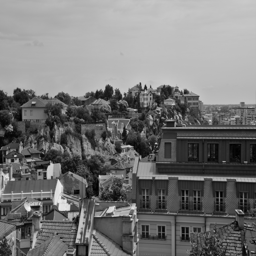

In [13]:
og_image = Image.open(full_path).convert("RGB").resize((256, 256))
display(ImageOps.grayscale(og_image))

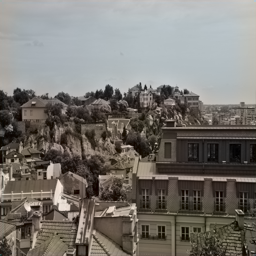

In [14]:
display(Image.fromarray(color, mode='RGB'))

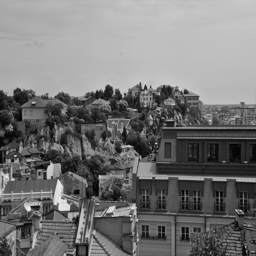

In [15]:
display(og_image)

In [ ]:
torch.save(colorizer.state_dict(), 'v5.model')

In [ ]:
!cp v5.model /content/drive/MyDrive